# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


#### Pickle the Datasets

From [forum post](https://discussions.udacity.com/t/resourceexhaustederror-in-dog-project-step-2-define-resnet50-model/528202). 

Pre-processing of the dataset takes up lot of memory. You can reload the pickle/h5py files instead of running the codes for pre-processing the dataset to avoid any memory issues.

Instead of running the codes in the project notebook all over again whenever you start the project, I suggest you to pickle the processed variables. For example, here’s how you can create the pickle files of training, testing and validation of paths to the image in AWS.

In [3]:
import pickle

pickle.dump( train_files, open( "train_files.p", "wb" ) )
pickle.dump( train_targets, open( "train_targets.p", "wb" ) )

pickle.dump( valid_files, open( "valid_files.p", "wb" ) )
pickle.dump( valid_targets, open( "valid_targets.p", "wb" ) )

pickle.dump( test_files, open( "test_files.p", "wb" ) )
pickle.dump( test_targets, open( "test_targets.p", "wb" ) )

pickle.dump( human_files, open( "human_files.p", "wb" ) )

#### Run to load files

You can load these pickle files on AWS project dog-app jupyter notebook as follows:

In [88]:
import pickle

train_files = pickle.load( open( "train_files.p", "rb" ) )
train_targets = pickle.load( open( "train_targets.p", "rb" ) )

valid_files = pickle.load( open( "valid_files.p", "rb" ) )
valid_targets = pickle.load( open( "valid_targets.p", "rb" ) )

test_files = pickle.load( open( "test_files.p", "rb" ) )
test_targets = pickle.load( open( "test_targets.p", "rb" ) )

human_files = pickle.load( open( "human_files.p", "rb" ) )

---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


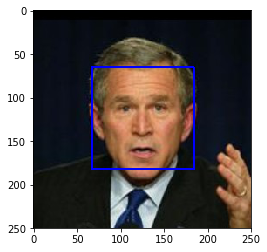

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[444])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

# return percentage of human faces detected in a list of image files
def percent_human_faces(img_file_list):
    human_face_count = 0
    for img in img_file_list:
        human_face_count += int(face_detector(img))
    return 100.0 * (float(human_face_count) / len(img_file_list))

print("Percentage of the first 100 images in human_files that have a detected human face: " + \
      str(percent_human_faces(human_files_short))+"%")

print("Percentage of the first 100 images in dog_files that have a detected human face: " + \
      str(percent_human_faces(dog_files_short))+"%")

Percentage of the first 100 images in human_files that have a detected human face: 98.0%
Percentage of the first 100 images in dog_files that have a detected human face: 11.0%


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ 
1. Well, maybe this is a reasonable expectation but the definition of "clear view of a face" likely means different things to different people. The problem I have found from testing several different images is that a face can be partially obscured and yet still have a clear view and not be identified as a face by OpenCV. As one option, the app might let the user know if the face was not detected. It would definitely be feasible to improve the face detection algorithm to detect partial faces by training the classifier using both clear as well as partially obscured faces. 

2. I suppose a CNN could be trained to detect faces that are obscured as well as fully visible. I need to think more on this...

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [8]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

In [8]:
# verify object 
ResNet50_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 230, 230, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472                                         
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256                                          
___________________________________________________________________________________________

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [10]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [12]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
# return percentage of human faces detected in a list of image files
def percent_dogs_detected(img_file_list):
    dog_count = 0
    for img in img_file_list:
        dog_count += int(dog_detector(img))
    return 100.0 * (float(dog_count) / len(img_file_list))

print("Percentage of the images in human_files_short that have a detected dog: " + \
      str(percent_dogs_detected(human_files_short))+"%")

print("Percentage of the images in dog_files_short that have a detected dog: " + \
      str(percent_dogs_detected(dog_files_short))+"%")

Percentage of the images in human_files_short that have a detected dog: 2.0%
Percentage of the images in dog_files_short that have a detected dog: 100.0%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:06<00:00, 138.34it/s]


#### Optional: Store the Tensor Variables
After preprocessing the data into the tensors, store the tensor variables into hdfs locally.

Refs: 
- [Transferring Files between your laptop and Amazon instance](http://angus.readthedocs.io/en/2014/amazon/transfer-files-between-instance.html)
- [h5py: reading and writing HDF5 files in Python](http://christopherlovell.co.uk/blog/2016/04/27/h5py-intro.html)

Use h5py as follows:

In [16]:
# create
import h5py

hf = h5py.File('data.h5', 'w')

hf.create_dataset('dataset_1', data=train_tensors)

hf.close() # writes to disk

In [ ]:
# read and restore
hf = h5py.File('data.h5', 'r')
n1 = hf.get('dataset_1')
np.array(n1)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 
1. Initially I wanted to see if I could replicate the sample provided, so designed the model to emulate the sample to see how it performs. 
- with 150 epochs, this model reaches __test accuracy: 12.5598%__
2. In my second model I enlarged the Conv2D kernel size to 3, since that captures more geometric information about the images, to see how that performs. 
- with 150 epochs, this model reaches __test accuracy: 17.7033%__

Note: Both graphs suggest that I could have used a larger training rate, because the change in accuracy progresses particularly slowly. Also, validation accuracy for both training and test sets is flattening but not yet horizontal, suggeting I could have increased the number of epochs. 

In [14]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
### TODO: Define your architecture.

# with an original conv2d kernel size of 2, reached Test accuracy: 12.5598%
# changed to 3,3 to evaluate difference

model.add(Conv2D(filters=16, kernel_size=3, padding='valid', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [16]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

# at 93 epochs the val loss did not improve and the test accuracy was 14%
# at 120 epocks the val loss continued to improve but test acc was 12%
# at 150 the val loss did not improve after 133 epochs and the test accuracy was 15%
epochs = 150

# NOTE: I added a history var below to save the model stats

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/150
6680/6680 [==============================] - 24s - loss: 4.8776 - acc: 0.0096 - val_loss: 4.8482 - val_acc: 0.0156
Epoch 2/150
6680/6680 [==============================] - 23s - loss: 4.8184 - acc: 0.0150 - val_loss: 4.7924 - val_acc: 0.0275
Epoch 3/150
6680/6680 [==============================] - 23s - loss: 4.7633 - acc: 0.0193 - val_loss: 4.7621 - val_acc: 0.0228
Epoch 4/150
6680/6680 [==============================] - 23s - loss: 4.7184 - acc: 0.0222 - val_loss: 4.7165 - val_acc: 0.0287
Epoch 5/150
6680/6680 [==============================] - 23s - loss: 4.6819 - acc: 0.0311 - val_loss: 4.7057 - val_acc: 0.0299
Epoch 6/150
6680/6680 [==============================] - 23s - loss: 4.6442 - acc: 0.0347 - val_loss: 4.6666 - val_acc: 0.0359
Epoch 7/150
6680/6680 [==============================] - 23s - loss: 4.6085 - acc: 0.0379 - val_loss: 4.6545 - val_acc: 0.0275
Epoch 8/150
6680/6680 [==============================] - 23s - l

6680/6680 [==============================] - 23s - loss: 4.0055 - acc: 0.1018 - val_loss: 4.1654 - val_acc: 0.0826
Epoch 28/150
6680/6680 [==============================] - 23s - loss: 3.9953 - acc: 0.1027 - val_loss: 4.2073 - val_acc: 0.0814
Epoch 29/150
6680/6680 [==============================] - 23s - loss: 3.9719 - acc: 0.1070 - val_loss: 4.2790 - val_acc: 0.0778
Epoch 30/150
6680/6680 [==============================] - 23s - loss: 3.9538 - acc: 0.1054 - val_loss: 4.1749 - val_acc: 0.0814
Epoch 31/150
6680/6680 [==============================] - 23s - loss: 3.9338 - acc: 0.1123 - val_loss: 4.0912 - val_acc: 0.0898
Epoch 32/150
6680/6680 [==============================] - 23s - loss: 3.9190 - acc: 0.1112 - val_loss: 4.1113 - val_acc: 0.0814
Epoch 33/150
6680/6680 [==============================] - 23s - loss: 3.8983 - acc: 0.1157 - val_loss: 4.1382 - val_acc: 0.0898
Epoch 34/150
6680/6680 [==============================] - 23s - loss: 3.8828 - acc: 0.1189 - val_loss: 4.2198 - val_a

6680/6680 [==============================] - 23s - loss: 3.5629 - acc: 0.1659 - val_loss: 3.9369 - val_acc: 0.1425
Epoch 58/150
6680/6680 [==============================] - 23s - loss: 3.5456 - acc: 0.1744 - val_loss: 3.9763 - val_acc: 0.1042
Epoch 59/150
6680/6680 [==============================] - 23s - loss: 3.5401 - acc: 0.1743 - val_loss: 3.9799 - val_acc: 0.1353
Epoch 60/150
6680/6680 [==============================] - 23s - loss: 3.5142 - acc: 0.1810 - val_loss: 3.9039 - val_acc: 0.1401
Epoch 61/150
6680/6680 [==============================] - 23s - loss: 3.4989 - acc: 0.1802 - val_loss: 3.9194 - val_acc: 0.1329
Epoch 62/150
6680/6680 [==============================] - 23s - loss: 3.5050 - acc: 0.1799 - val_loss: 3.8969 - val_acc: 0.1473
Epoch 63/150
6680/6680 [==============================] - 23s - loss: 3.4769 - acc: 0.1828 - val_loss: 3.9573 - val_acc: 0.1437
Epoch 64/150
6680/6680 [==============================] - 23s - loss: 3.4627 - acc: 0.1909 - val_loss: 3.8459 - val_a

6680/6680 [==============================] - 23s - loss: 3.2354 - acc: 0.2250 - val_loss: 4.1001 - val_acc: 0.1401
Epoch 88/150
6680/6680 [==============================] - 23s - loss: 3.2228 - acc: 0.2286 - val_loss: 3.7204 - val_acc: 0.1772
Epoch 89/150
6680/6680 [==============================] - 23s - loss: 3.2099 - acc: 0.2353 - val_loss: 3.8410 - val_acc: 0.1605
Epoch 90/150
6680/6680 [==============================] - 23s - loss: 3.2002 - acc: 0.2313 - val_loss: 3.7905 - val_acc: 0.1593
Epoch 91/150
6680/6680 [==============================] - 23s - loss: 3.1964 - acc: 0.2352 - val_loss: 3.6832 - val_acc: 0.1868
Epoch 92/150
6680/6680 [==============================] - 23s - loss: 3.1898 - acc: 0.2404 - val_loss: 3.7054 - val_acc: 0.1605
Epoch 93/150
6680/6680 [==============================] - 23s - loss: 3.1780 - acc: 0.2322 - val_loss: 3.7276 - val_acc: 0.1725
Epoch 94/150
6680/6680 [==============================] - 23s - loss: 3.1708 - acc: 0.2404 - val_loss: 3.8512 - val_a

6680/6680 [==============================] - 23s - loss: 2.9895 - acc: 0.2692 - val_loss: 3.6237 - val_acc: 0.1880
Epoch 118/150
6680/6680 [==============================] - 23s - loss: 3.0022 - acc: 0.2719 - val_loss: 3.6118 - val_acc: 0.1856
Epoch 119/150
6680/6680 [==============================] - 23s - loss: 2.9891 - acc: 0.2687 - val_loss: 3.6634 - val_acc: 0.1713
Epoch 120/150
6680/6680 [==============================] - 23s - loss: 2.9766 - acc: 0.2783 - val_loss: 3.7894 - val_acc: 0.1653
Epoch 121/150
6680/6680 [==============================] - 23s - loss: 2.9766 - acc: 0.2726 - val_loss: 3.7069 - val_acc: 0.1856
Epoch 122/150
6680/6680 [==============================] - 23s - loss: 2.9571 - acc: 0.2778 - val_loss: 3.7602 - val_acc: 0.1629
Epoch 123/150
6680/6680 [==============================] - 23s - loss: 2.9528 - acc: 0.2825 - val_loss: 3.7444 - val_acc: 0.1940
Epoch 124/150
6680/6680 [==============================] - 23s - loss: 2.9365 - acc: 0.2754 - val_loss: 3.6579 

6680/6680 [==============================] - 23s - loss: 2.7960 - acc: 0.3087 - val_loss: 3.7033 - val_acc: 0.1964
Epoch 150/150
6680/6680 [==============================] - 23s - loss: 2.7892 - acc: 0.3130 - val_loss: 3.6459 - val_acc: 0.2036


### Load the Model with the Best Validation Loss

In [17]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [18]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 17.7033%


### Plot the Model Results

To help evaluate performance for the number of epochs and kernel size changes, I plotted loss and accuracy for both training and validation. 

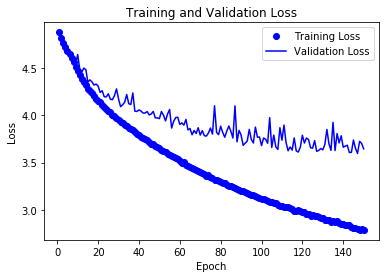

In [21]:
# plot the training and validation metrics
import matplotlib.pyplot as plt

def plot_train_loss(history):
    history_dict = history.history
    loss_vals = history_dict['loss']
    val_loss_vals = history_dict['val_loss']

    # epoch num on x-axis
    epochs = range(1, len(loss_vals)+1)

    plt.plot(epochs, loss_vals, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss_vals, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
plot_train_loss(history)

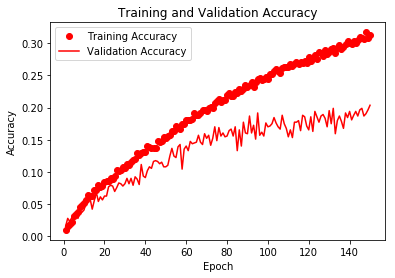

In [22]:
def plot_train_acc(history):
    history_dict = history.history
    acc_vals = history_dict['acc']
    val_acc_vals = history_dict['val_acc']

    # epoch num on x-axis
    epochs = range(1, len(acc_vals)+1)
    
    plt.plot(epochs, acc_vals, 'ro', label='Training Accuracy')
    plt.plot(epochs, val_acc_vals, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_train_acc(history)

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [24]:
import numpy as np

bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [25]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [26]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In this task, I increased the number of epochs to 100 from the original 20 epochs to get better convergence, based on looking at the accuracy visualization plots. 

This model yields a Test accuracy: 54.0670%. Based on the plots the number of epochs is sufficient and could be cut back to about 80. 

In [27]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

# increased the number of epochs to 100 from 20 to get better convergence
breed_epochs = 100

breed_history = VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=breed_epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/100
6680/6680 [==============================] - 1s - loss: 11.8148 - acc: 0.1368 - val_loss: 10.0214 - val_acc: 0.2455
Epoch 2/100
6680/6680 [==============================] - 1s - loss: 9.3040 - acc: 0.3159 - val_loss: 9.2074 - val_acc: 0.3365
Epoch 3/100
6680/6680 [==============================] - 1s - loss: 8.5476 - acc: 0.3946 - val_loss: 8.7751 - val_acc: 0.3593
Epoch 4/100
6680/6680 [==============================] - 1s - loss: 8.2589 - acc: 0.4368 - val_loss: 8.6949 - val_acc: 0.3665
Epoch 5/100
6680/6680 [==============================] - 1s - loss: 8.0631 - acc: 0.4575 - val_loss: 8.5780 - val_acc: 0.3868
Epoch 6/100
6680/6680 [==============================] - 1s - loss: 7.9484 - acc: 0.4756 - val_loss: 8.5312 - val_acc: 0.3964
Epoch 7/100
6680/6680 [==============================] - 1s - loss: 7.8927 - acc: 0.4862 - val_loss: 8.4550 - val_acc: 0.4168
Epoch 8/100
6680/6680 [==============================] - 1s - loss: 7

6680/6680 [==============================] - 1s - loss: 6.3827 - acc: 0.6006 - val_loss: 7.3682 - val_acc: 0.4647
Epoch 28/100
6680/6680 [==============================] - 1s - loss: 6.3748 - acc: 0.6024 - val_loss: 7.2693 - val_acc: 0.4838
Epoch 29/100
6680/6680 [==============================] - 1s - loss: 6.3691 - acc: 0.6037 - val_loss: 7.3001 - val_acc: 0.4874
Epoch 30/100
6680/6680 [==============================] - 1s - loss: 6.3673 - acc: 0.6031 - val_loss: 7.2756 - val_acc: 0.4754
Epoch 31/100
6680/6680 [==============================] - 1s - loss: 6.3191 - acc: 0.6030 - val_loss: 7.2330 - val_acc: 0.4766
Epoch 32/100
6680/6680 [==============================] - 1s - loss: 6.2537 - acc: 0.6057 - val_loss: 7.1360 - val_acc: 0.4814
Epoch 33/100
6680/6680 [==============================] - 1s - loss: 6.2172 - acc: 0.6105 - val_loss: 7.2006 - val_acc: 0.4838
Epoch 34/100
6680/6680 [==============================] - 1s - loss: 6.2098 - acc: 0.6121 - val_loss: 7.1520 - val_acc: 0.49

6680/6680 [==============================] - 1s - loss: 5.5268 - acc: 0.6564 - val_loss: 6.6636 - val_acc: 0.5198
Epoch 58/100
6680/6680 [==============================] - 1s - loss: 5.5256 - acc: 0.6564 - val_loss: 6.7080 - val_acc: 0.5222
Epoch 59/100
6680/6680 [==============================] - 1s - loss: 5.5272 - acc: 0.6564 - val_loss: 6.7152 - val_acc: 0.5210
Epoch 60/100
6680/6680 [==============================] - 1s - loss: 5.5252 - acc: 0.6569 - val_loss: 6.7550 - val_acc: 0.5114
Epoch 61/100
6680/6680 [==============================] - 1s - loss: 5.5137 - acc: 0.6567 - val_loss: 6.8227 - val_acc: 0.5054
Epoch 62/100
6680/6680 [==============================] - 1s - loss: 5.4588 - acc: 0.6567 - val_loss: 6.7376 - val_acc: 0.5174
Epoch 63/100
6680/6680 [==============================] - 1s - loss: 5.4161 - acc: 0.6617 - val_loss: 6.6544 - val_acc: 0.5162
Epoch 64/100
6680/6680 [==============================] - 1s - loss: 5.4023 - acc: 0.6635 - val_loss: 6.6363 - val_acc: 0.52

6680/6680 [==============================] - 1s - loss: 5.3943 - acc: 0.6651 - val_loss: 6.6597 - val_acc: 0.5246
Epoch 90/100
6680/6680 [==============================] - 1s - loss: 5.3941 - acc: 0.6651 - val_loss: 6.6869 - val_acc: 0.5317
Epoch 91/100
6680/6680 [==============================] - 1s - loss: 5.3943 - acc: 0.6653 - val_loss: 6.6656 - val_acc: 0.5293
Epoch 92/100
6680/6680 [==============================] - 1s - loss: 5.3943 - acc: 0.6651 - val_loss: 6.6565 - val_acc: 0.5305
Epoch 93/100
6680/6680 [==============================] - 1s - loss: 5.3929 - acc: 0.6653 - val_loss: 6.6589 - val_acc: 0.5293
Epoch 94/100
6680/6680 [==============================] - 1s - loss: 5.3919 - acc: 0.6653 - val_loss: 6.7334 - val_acc: 0.5138
Epoch 95/100
6680/6680 [==============================] - 1s - loss: 5.3912 - acc: 0.6653 - val_loss: 6.7143 - val_acc: 0.5222
Epoch 96/100
6680/6680 [==============================] - 1s - loss: 5.3876 - acc: 0.6654 - val_loss: 6.6921 - val_acc: 0.52

### Load the Model with the Best Validation Loss

In [28]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [29]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 54.0670%


In [30]:
import matplotlib.pyplot as plt

def plot_train_loss(history):
    history_dict = history.history
    loss_vals = history_dict['loss']
    val_loss_vals = history_dict['val_loss']

    # epoch num on x-axis
    epochs = range(1, len(loss_vals)+1)

    plt.plot(epochs, loss_vals, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss_vals, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def plot_train_acc(history):
    history_dict = history.history
    acc_vals = history_dict['acc']
    val_acc_vals = history_dict['val_acc']

    # epoch num on x-axis
    epochs = range(1, len(acc_vals)+1)
    
    plt.plot(epochs, acc_vals, 'ro', label='Training Accuracy')
    plt.plot(epochs, val_acc_vals, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

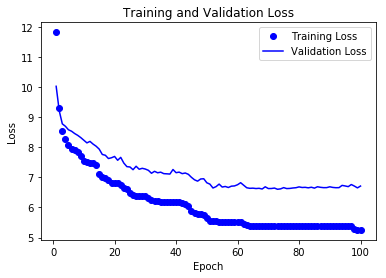

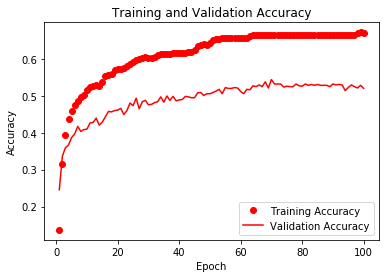

In [31]:
plot_train_loss(breed_history)
plot_train_acc(breed_history)

### Predict Dog Breed with the Model

In [32]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [90]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

# obtained DogResnet50Data.npz
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

# verify
print("Training set shape:   (%s, %s, %s)" % (train_Resnet50.shape[0], train_Resnet50.shape[1], train_Resnet50.shape[2]))
print("Validation set shape: (%s, %s, %s)" % (valid_Resnet50.shape[0], valid_Resnet50.shape[1], valid_Resnet50.shape[2]))
print("Test set shape:       (%s, %s, %s)" % (test_Resnet50.shape[0], test_Resnet50.shape[1], test_Resnet50.shape[2]))


Training set shape:   (6680, 1, 1)
Validation set shape: (835, 1, 1)
Test set shape:       (836, 1, 1)


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem. (Detail why the chosen architecture succeeded in the classification task and why earlier attempts were not as successful.)

__Answer:__ Here I took exactly the same steps as in the Step 4 case, except with the ResNet50 model. I modified the epochs and training rate as follows:
- 20 epochs and lr=0.0001, Test accuracy: 82.6555%
- 40 epochs and lr=0.0001, Test accuracy: 83.0144%



In [91]:
### TODO: Define your architecture.

Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [92]:
### TODO: Compile the model.
from keras import optimizers

Resnet50_model.compile(loss='categorical_crossentropy', optimizer=optimizers.rmsprop(lr=0.0001), metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [93]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

# 20 epochs and lr=0.0001, Test accuracy: 82.6555%
# 40 epochs and lr=0.0001, Test accuracy: 83.0144%
breed_history = Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=40, batch_size=20, callbacks=[checkpointer], verbose=1)


Train on 6680 samples, validate on 835 samples
Epoch 1/40
6680/6680 [==============================] - 11s - loss: 3.8008 - acc: 0.2094 - val_loss: 2.5843 - val_acc: 0.4766
Epoch 2/40
6680/6680 [==============================] - 2s - loss: 1.8234 - acc: 0.6266 - val_loss: 1.5227 - val_acc: 0.6695
Epoch 3/40
6680/6680 [==============================] - 2s - loss: 1.0871 - acc: 0.7683 - val_loss: 1.1183 - val_acc: 0.7293
Epoch 4/40
6680/6680 [==============================] - 2s - loss: 0.7732 - acc: 0.8274 - val_loss: 0.9295 - val_acc: 0.7629
Epoch 5/40
6680/6680 [==============================] - 2s - loss: 0.6072 - acc: 0.8615 - val_loss: 0.8223 - val_acc: 0.7772
Epoch 6/40
6680/6680 [==============================] - 2s - loss: 0.5064 - acc: 0.8784 - val_loss: 0.7447 - val_acc: 0.7916
Epoch 7/40
6680/6680 [==============================] - 2s - loss: 0.4354 - acc: 0.8942 - val_loss: 0.7077 - val_acc: 0.7964
Epoch 8/40
6680/6680 [==============================] - 2s - loss: 0.3849 - a

6680/6680 [==============================] - 1s - loss: 0.1223 - acc: 0.9653 - val_loss: 0.5478 - val_acc: 0.8359
Epoch 29/40
6680/6680 [==============================] - 1s - loss: 0.1188 - acc: 0.9668 - val_loss: 0.5470 - val_acc: 0.8311
Epoch 30/40
6680/6680 [==============================] - 1s - loss: 0.1147 - acc: 0.9678 - val_loss: 0.5547 - val_acc: 0.8347
Epoch 31/40
6680/6680 [==============================] - 2s - loss: 0.1109 - acc: 0.9684 - val_loss: 0.5500 - val_acc: 0.8455
Epoch 32/40
6680/6680 [==============================] - 2s - loss: 0.1083 - acc: 0.9704 - val_loss: 0.5477 - val_acc: 0.8371
Epoch 33/40
6680/6680 [==============================] - 1s - loss: 0.1046 - acc: 0.9702 - val_loss: 0.5584 - val_acc: 0.8383
Epoch 34/40
6680/6680 [==============================] - 1s - loss: 0.1007 - acc: 0.9740 - val_loss: 0.5550 - val_acc: 0.8407
Epoch 35/40
6680/6680 [==============================] - 1s - loss: 0.0997 - acc: 0.9734 - val_loss: 0.5602 - val_acc: 0.8323
Epoc

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [94]:
### TODO: Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

Test accuracy: 83.0144%


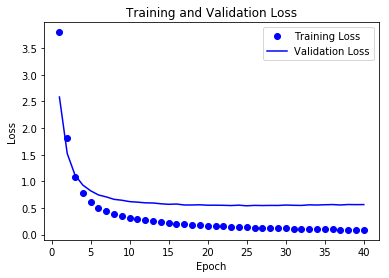

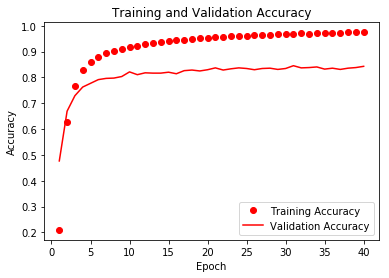

In [95]:
### TODO: Calculate classification accuracy on the test dataset.
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

plot_train_loss(breed_history)
plot_train_acc(breed_history)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [96]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

Resnet50_predict_breed("./images/Brittany_02625.jpg")

'Brittany'

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [97]:
### Write an algorithm that:
### 1) Accepts a file path to an image 
### 2) Determines whether the image contains a human, dog, or neither. 
### 3) Then:
###    - if a dog is detected in the image, return the predicted breed.
###    - if a human is detected in the image, return the resembling dog breed.
###    - if neither is detected in the image, provide output that indicates an error.
###
### Algo will use earlier implementations for the face_detector and dog_detector functions. 
### Algo uses the CNN from Step 5 to predict dog breed. 

# setup
import cv2  
import os.path
import matplotlib.pyplot as plt                        
%matplotlib inline 

# constructor for cv2 classifier
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')


In [98]:
# Modification of the face_detector defined above to return the faces array
# if no human is detected, returns 0
# inputs: img_path: full path to image 
# returns: list of face bounding boxes detected in image stored at img_path
def detect_human_faces(human_img_path):
    human_img = cv2.imread(human_img_path)
    gray = cv2.cvtColor(human_img, cv2.COLOR_BGR2GRAY)
    return face_cascade.detectMultiScale(gray)

# return True if one or more human faces detected
def face_detector(human_img_path):
    return len(detect_human_faces(human_img_path)) > 0

# display image
def display_image(disp_img_path):
    disp_img = cv2.imread(disp_img_path)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(disp_img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    

In [99]:
# worker function implementing the algorithm to determine and display the predicted breed from an image
# 
def display_breed_prediction(path_to_image):
    # minor error handling 
    if path_to_image == None or path_to_image == "":
        return "Variable \"path_to_image\" in function \"dog_breed_predictor\" is None."
    # check if file exists to avoid nasty cv2 error
    if not os.path.isfile(path_to_image):
        return "Non-valid file in variable \"path_to_image\" passed to function \"dog_breed_predictor\". "

    breed = None
    header_text = ""
    footer_text = ""
    
    # if dog detected in the image, get the breed and the image of the dog
    if dog_detector(path_to_image):
        breed = Resnet50_predict_breed(path_to_image)
        header_text = "Hello Dog!"
        footer_text = "Your breed appears to be " + breed + "."
    # if human detected in the image, get the look-alike breed 
    elif face_detector(path_to_image):
        breed = Resnet50_predict_breed(path_to_image)
        header_text = "Hello Human!"
        footer_text = "Your look-alike breed is " + breed + "."
    # else neither is detected in the image, return error text
    else:
        header_text = "Sorry, we can't tell what you are!"
        footer_text = "Please submit a different image."
        
    print(header_text)
    display_image(path_to_image)
    print(footer_text)
    print("____________________________________\n")
    

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ Bettter than expected! The algorithm::
- Successfully rejected the moose and the cat (furry objects)
- Successfully rejected the human (little girl) where it could not see the face
- Successfully classified the dog breeds for pure breeds
- Made a reasonable guess at a non-pure breed with two dogs in the image
- Successfully identified the humans and attempted to classify their breeds

__Possible Improvements:__
1. Output confidence level as a %
2. Detect more than dog if more than one in image
3. Attempt other animal identifications if the animal is not a dog


Sorry, we can't tell what you are!


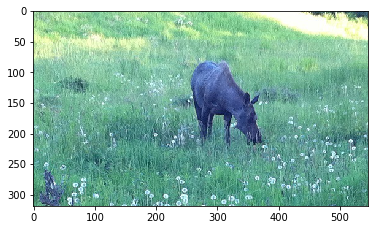

Please submit a different image.
____________________________________

Sorry, we can't tell what you are!


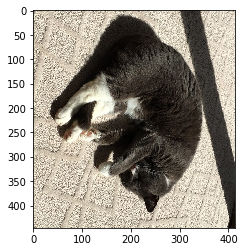

Please submit a different image.
____________________________________

Hello Dog!


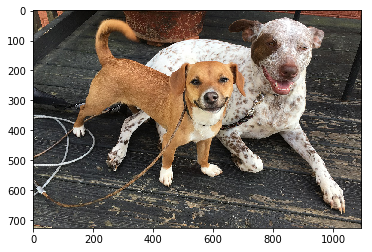

Your breed appears to be Lakeland_terrier.
____________________________________

Hello Human!


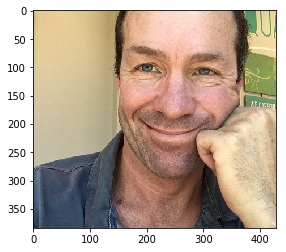

Your look-alike breed is Chesapeake_bay_retriever.
____________________________________

Sorry, we can't tell what you are!


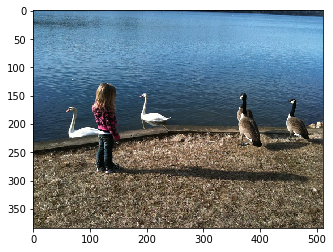

Please submit a different image.
____________________________________

Hello Human!


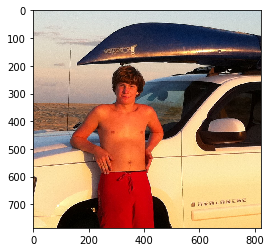

Your look-alike breed is Great_dane.
____________________________________

Hello Dog!


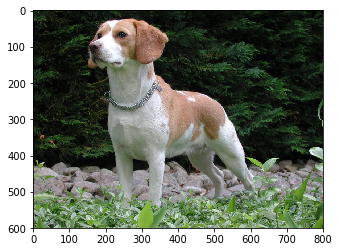

Your breed appears to be Beagle.
____________________________________

Hello Dog!


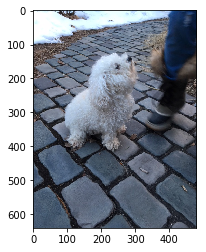

Your breed appears to be Lowchen.
____________________________________

Hello Dog!


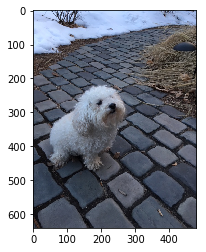

Your breed appears to be Petit_basset_griffon_vendeen.
____________________________________

Hello Dog!


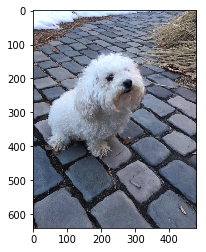

Your breed appears to be Bichon_frise.
____________________________________



In [100]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

# create image list for testing of at least six images, with at least two human and two dog images
test_images = ["./test_images/moose.JPG",
               "./test_images/sleeping_cat.jpg",
               "./test_images/two_dogs.JPG",
               "./test_images/kcm_crop.jpg",
               "./test_images/girl_with_birds.JPG",
               "./test_images/boy_beach.JPG",
               "./test_images/Beagle_Upsy.jpg",
               "./test_images/IMG_4130.JPG",
               "./test_images/IMG_4131.JPG",
               "./test_images/IMG_4132.JPG"         
              ]

# verify image list meets requirements
assert len(test_images) >= 6

# loop through the images and display
for test_image in test_images:
    display_breed_prediction(test_image)